In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import random
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy
from scipy.stats import rankdata

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Define the model
class Net(nn.Module):
  def __init__(self, in_features):
    super().__init__()

    layer1_size = round(in_features - (in_features/3))
    layer2_size = round(in_features - ((2/3)*in_features))
    ##feedfoward layers:
    self.ff1 = nn.Linear(in_features, layer1_size) # input dimension is 2, first hidden layer is 10
    self.ff2 = nn.Linear(layer1_size, layer2_size) # second hidden layer is 2
    self.ff_out = nn.Linear(layer2_size, 1)  # output layer is 1

    ##activation:
    # self.act = nn.Sigmoid()
    self.act = nn.ReLU()

    if torch.cuda.is_available():
      self.cuda()


  def forward(self, input_data):
    input_data = torch.as_tensor(input_data, dtype=torch.float)
    out = self.act(self.ff1(input_data))
    out = self.act(self.ff2(out))
    out = self.ff_out(out)
    return out #returns classification for each image


  def xavier_weights(self):
    nn.init.xavier_uniform_(self.ff1.weight)
    nn.init.xavier_uniform_(self.ff2.weight)
    nn.init.xavier_uniform_(self.ff_out.weight)

In [5]:
# TODO: is this the right accuracy metric for continuous variables? how do I use MSE to get accuracy?
# define training and test loss/accuracy functions
# def calc_err(y_pred, y_test):
#   err = (
#       torch.sum(torch.square(torch.subtract(y_pred, y_test)))
#       )/y_pred.size(dim=1)
#   return err

# def calc_err(y_pred, y_test):
#   err = (torch.sum(torch.square(torch.subtract(y_pred, y_test))))

#   return err

def calc_err(y_pred, y_test):
  y_test = y_test.detach().numpy()
  y_pred = y_pred.detach().numpy()
  err = mean_squared_error(y_test, y_pred)

  # print("calc_err, y_test: ", y_test)
  # print("calc_err, y_pred: ", y_pred)
  # print("calc_err, err: ", err)

  return err

# Function to plot data for a certain seed
def plot_loss_acc(plot_data, index):
  plt.figure(index)
  ax = plt.gca()

  # change plot_data into a np array
  data = np.array(plot_data)
  x = data[:,0]           # first column is the epoch count
  train_loss = data[:,1]  # second column is train loss
  train_acc = data[:,2]   # 3rd column is train accuracy
  test_acc = data[:,3]    # 4th column is test accuracy

  ax.plot(train_loss, label = 'Train Loss')
  ax.plot(test_acc, label = 'Test Error')
  ax.legend()
  # ax.set_ylim([0.0, 1.0])
  plt.xlabel('Epochs')
  plt.title('Train Loss and Test Error for Seed %d' %index)

In [7]:
# function for training model
def train_model(model, train_loader, test_loader, epochs=300, seed=3):

  # keep output fixed
  torch.manual_seed(seed)
  random.seed(seed)

  # reset parameters
  model.xavier_weights()

  plot_data = []

  for epoch in range(epochs):
    # debug
    print(epoch)

    tot_train_loss = 0
    tot_train_err = 0
    tot_test_err = 0

    batch_num = 0

    # calculate training loss and acc
    for x_train, y_train in train_loader:
      # print(x_train.shape)
      # print(y_train.shape)
      # batch_num = batch_num + 1
      # print("batch num: ", batch_num)

      x_train, y_train = x_train.to(device), y_train.to(device)

      optimizer.zero_grad()

      model.train()
      yhat = model(x_train)
      loss = loss_metric(yhat, y_train)

      # debug
      # print("yhat: ", yhat, ". yhat type: ", type(yhat))
      # print("y_train: ", y_train, ". y_train type: ", type(yhat))

      epoch_train_err = calc_err(yhat,y_train)
      loss.backward()
      optimizer.step()

      tot_train_loss += loss.item()
      tot_train_err += epoch_train_err.item()

    test_y_pred = []
    test_y_truth = []

    # calculate testing loss and acc
    model.eval()
    with torch.no_grad():
      for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        yhat = model(x_test)

        epoch_test_err = calc_err(yhat, y_test)

        tot_test_err += epoch_test_err

        test_y_pred = yhat
        test_y_truth = y_test

        # debug
        # print("current total test error: ", tot_test_err)

    plot_data.append([epoch, tot_train_loss/len(train_loader), tot_train_err/len(train_loader), tot_test_err/len(test_loader)])
    print(f'Epoch {epoch+0:03}: | Loss: {tot_train_loss/len(train_loader):.5f} | TrainErr: {tot_train_err/len(train_loader):.3f} | TestErr: {tot_test_err/len(test_loader):.3f}')

  return plot_data, test_y_pred, test_y_truth

In [9]:
# load the data

# Cokie's google drive paths:
data_base_path = '/content/gdrive/MyDrive/ML/CMI-PB Data/data/'
rnaseq_filtered_data_path = data_base_path + 'RNAseqRawBatchCorrectedFiltered.tsv'
rnaseq_metadata_path = data_base_path + 'RNAseqMetaData.tsv'
abtiter_normalized_path = data_base_path + 'AbtiterNormalizedData.tsv'
abtiter_metadata_path = data_base_path + 'AbtiterMetadata.tsv'
cellfreq_normalized_path = data_base_path + 'CytofBatchCorrectedData.tsv'
cellfreq_metadata_path = data_base_path + 'CytofMetadata.tsv'
cytokine_normalized_path = data_base_path + 'CytokineBatchCorrectedData.tsv'
cytokine_metadata_path = data_base_path + 'CytokineMetadata.tsv'

rnaseq_filtered_data_raw = pd.read_csv(rnaseq_filtered_data_path, sep='\t')
rnaseq_metadata = pd.read_csv(rnaseq_metadata_path, sep='\t')
abtiter_normalized_data_raw = pd.read_csv(abtiter_normalized_path, sep='\t')
abtiter_metadata = pd.read_csv(abtiter_metadata_path, sep='\t')
cellfreq_normalized_data_raw = pd.read_csv(cellfreq_normalized_path, sep='\t')
cellfreq_metadata = pd.read_csv(cellfreq_metadata_path, sep='\t')
cytokine_normalized_data_raw = pd.read_csv(cytokine_normalized_path, sep='\t')
cytokine_metadata = pd.read_csv(cytokine_metadata_path, sep='\t')

# skipping additional normalization for now because we are using TMP counts (already normalized)

In [10]:
# see if metadata has the right number of individuals
rnaseq_test0 = rnaseq_metadata.drop_duplicates(subset=['subject_id'])
print(rnaseq_test0.shape)
numSamples = 72

abtiter_test0 = abtiter_metadata.drop_duplicates(subset=['subject_id'])
print(abtiter_test0.shape)

cellfreq_test0 = cellfreq_metadata.drop_duplicates(subset=['subject_id'])
print(cellfreq_test0.shape)

cytokine_test0 = cytokine_metadata.drop_duplicates(subset=['subject_id'])
print(cytokine_test0.shape)

(72, 14)
(96, 14)
(96, 14)
(96, 14)


In [11]:
# load data for rnaseq
rnaseq_metadata_subset = rnaseq_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
data_transposed = rnaseq_filtered_data_raw.T
data_transposed.index.name = 'specimen_id'
data_transposed.reset_index(inplace=True)
data_transposed['specimen_id'] = pd.to_numeric(data_transposed['specimen_id'])
data_merged = data_transposed.merge(rnaseq_metadata_subset, how='left', on='specimen_id')
data_merged_subsetted = data_merged[data_merged['planned_day_relative_to_boost'].isin([0, 3])]

print("All data points (input and output), should be 144 long: ", data_merged_subsetted.shape)

# format data and split into input and output (x and y, input and label)
data_groups = data_merged_subsetted.groupby('planned_day_relative_to_boost')
data_x = data_groups.get_group(0).drop(['planned_day_relative_to_boost'], axis=1)
data_y = data_groups.get_group(3)[['ENSG00000277632.1', 'subject_id']]
data_x.sort_values(by='subject_id', inplace=True)
data_y.sort_values(by='subject_id', inplace=True)

print("All input (x) data points, should be 72 long: ", data_x.shape)
print("All output (y, label) data points, should be 72 long: ", data_y.shape)

# split data into training and testing
numTrain = round(numSamples * 0.9)
numTest = numSamples - numTrain

training_data_x = data_x.head(numTrain)
training_data_y = data_y.head(numTrain)
test_data_x = data_x.tail(numTest)
test_data_y = data_y.tail(numTest)

print("Training x and y still in same order: ", training_data_x['subject_id'].tolist() == training_data_y['subject_id'].tolist())
print("Test x and y still in same order: ", test_data_x['subject_id'].tolist() == test_data_y['subject_id'].tolist())

training_data_x = data_x.drop(['subject_id'], axis=1)
training_data_y = data_y.drop(['subject_id'], axis=1)
test_data_x = data_x.drop(['subject_id'], axis=1)
test_data_y = data_y.drop(['subject_id'], axis=1)

print(training_data_x.shape)
print(training_data_y.shape)

print(test_data_x.shape)
print(test_data_y.shape)

All data points (input and output), should be 144 long:  (144, 8245)
All input (x) data points, should be 72 long:  (72, 8244)
All output (y, label) data points, should be 72 long:  (72, 2)
Training x and y still in same order:  True
Test x and y still in same order:  True
(72, 8243)
(72, 1)
(72, 8243)
(72, 1)


In [12]:
# Define your dataloaders
tensor_X_train = torch.Tensor(training_data_x.to_numpy())
tensor_Y_train = torch.Tensor(training_data_y.to_numpy())
tensor_X_test = torch.Tensor(test_data_x.to_numpy())
tensor_Y_test = torch.Tensor(test_data_y.to_numpy())

train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size = 10, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = 10, shuffle=False)

# instantiate model
rnaseq_net = Net(8243)
rnaseq_net.to(device)

# define optimizer and loss
# TODO: consider using adam optimizer
optimizer = torch.optim.SGD(rnaseq_net.parameters(), lr = 0.00001, weight_decay=0.001)
loss_metric = nn.MSELoss()

# train model using 5 random seeds
train_accuracies = []
test_accuracies = []
epochs = 10
for i in range(1):
  plot_data=train_model(rnaseq_net, train_loader, test_loader, epochs, i)

  train_accuracies.append(np.array(plot_data)[(epochs - 1),2])
  test_accuracies.append(np.array(plot_data)[(epochs - 1),3])

  plot_loss_acc(plot_data, i)

0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


ValueError: Input contains NaN.

In [13]:
# Test accuracy on test set
print("train mean:", np.mean(train_accuracies))
print("train stddv:", np.std(train_accuracies))
print("test mean:", np.mean(test_accuracies))
print("test stddv:", np.std(test_accuracies))

train mean: nan
train stddv: nan
test mean: nan
test stddv: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Now train the same model but on input=(abtiters, cell frequency, cytokine concentrations) and output=(Pertussis Toxin (PT) IgG titers):

In [14]:
## load data for abtiters
abtiter_metadata_subset = abtiter_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
abtiter_data_transposed = abtiter_normalized_data_raw.T
abtiter_data_transposed.index.name = 'specimen_id'
abtiter_data_transposed.reset_index(inplace=True)
abtiter_data_transposed['specimen_id'] = pd.to_numeric(abtiter_data_transposed['specimen_id'])
abtiter_data_merged = abtiter_data_transposed.merge(abtiter_metadata_subset, how='left', on='specimen_id')
abtiter_data_merged_subsetted = abtiter_data_merged[abtiter_data_merged['planned_day_relative_to_boost'].isin([0, 14])]

print("All abtiter data points (input and output), should be 180 long: ", abtiter_data_merged_subsetted.shape)

## load data for cell frequency
cellfreq_metadata_subset = cellfreq_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
cellfreq_data_transposed = cellfreq_normalized_data_raw.T
cellfreq_data_transposed.index.name = 'specimen_id'
cellfreq_data_transposed.reset_index(inplace=True)
cellfreq_data_transposed['specimen_id'] = pd.to_numeric(cellfreq_data_transposed['specimen_id'])
cellfreq_data_merged = cellfreq_data_transposed.merge(cellfreq_metadata_subset, how='left', on='specimen_id')
cellfreq_data_merged_subsetted = cellfreq_data_merged[cellfreq_data_merged['planned_day_relative_to_boost'].isin([0, 14])]

print("All cell freq data points (input and output), should be 106 long: ", cellfreq_data_merged_subsetted.shape)

## load data for cytokine concentrations
cytokine_metadata_subset = cytokine_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
cytokine_data_transposed = cytokine_normalized_data_raw.T
cytokine_data_transposed.index.name = 'specimen_id'
cytokine_data_transposed.reset_index(inplace=True)
cytokine_data_transposed['specimen_id'] = pd.to_numeric(cytokine_data_transposed['specimen_id'])
cytokine_data_merged = cytokine_data_transposed.merge(cytokine_metadata_subset, how='left', on='specimen_id')
cytokine_data_merged_subsetted = cytokine_data_merged[cytokine_data_merged['planned_day_relative_to_boost'].isin([0, 14])]

print("All cytokine data points (input and output), should be 108 long: ", cytokine_data_merged_subsetted.shape)

All abtiter data points (input and output), should be 180 long:  (181, 30)
All cell freq data points (input and output), should be 106 long:  (106, 23)
All cytokine data points (input and output), should be 108 long:  (108, 33)


Now re-run day 14 IgG-PT abtiter values for input data that has imputed values instead of cutting out all samples that dont have an entry for every datatype.

(array([ 1.,  0., 10., 21., 25., 29., 15.,  4.,  1.,  2.]),
 array([0.42702852, 0.54152031, 0.6560121 , 0.77050389, 0.88499568,
        0.99948746, 1.11397925, 1.22847104, 1.34296283, 1.45745462,
        1.5719464 ]),
 <BarContainer object of 10 artists>)

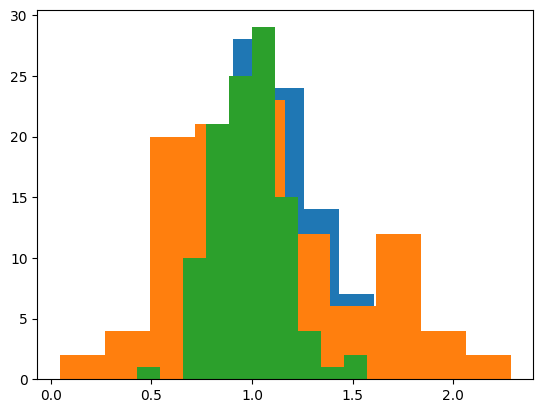

In [15]:
# plot histogram of cytokine, cell frequency, and abtiter data
plt.hist(cytokine_data_merged_subsetted['O14625'])
plt.hist(cellfreq_data_merged_subsetted['Classical_Monocytes'])
plt.hist(cytokine_data_merged_subsetted['O43508'])

In [77]:
# combine the data types, then impute any values that are missing for
# cell freq, cytokines, abtiters
all_titerPred_data = pd.merge(abtiter_data_transposed, cellfreq_data_transposed, how='left', on='specimen_id')
all_titerPred_data = pd.merge(all_titerPred_data, cytokine_data_transposed, how='left', on='specimen_id')
all_titerPred_data['specimen_id'] = pd.to_numeric(abtiter_data_transposed['specimen_id'])
all_titerPred_merged_metadata = all_titerPred_data.merge(abtiter_metadata_subset, how='left', on='specimen_id')
all_titerPred_time_subset = all_titerPred_merged_metadata[all_titerPred_merged_metadata['planned_day_relative_to_boost'].isin([0, 14])]

# make sure data only has complete sets of timepoint 0 and 14 for each subject
subject_dict = {}
for index, row in all_titerPred_time_subset.iterrows():
  if row['subject_id'] in subject_dict:
    subject_dict[row['subject_id']] = subject_dict[row['subject_id']] + 1
  else:
    subject_dict[row['subject_id']] = 1

completeSubjects = []
for elem in subject_dict:
  if subject_dict[elem] == 2:
    completeSubjects.append(elem)

all_titerPred_mask = all_titerPred_time_subset['subject_id'].isin(completeSubjects)
all_titerPred_complete = all_titerPred_time_subset[all_titerPred_mask]

# split data into input (x), and output (y, label)
combined_toImpute_titerPred = all_titerPred_complete.groupby('planned_day_relative_to_boost')
data_x = combined_toImpute_titerPred.get_group(0).drop(['planned_day_relative_to_boost'], axis=1)
data_y = combined_toImpute_titerPred.get_group(14)[['IgG_PT', 'subject_id']]
data_x.sort_values(by='subject_id', inplace=True)
data_y.sort_values(by='subject_id', inplace=True)

data_x = data_x.drop(['subject_id'], axis=1)
data_y = data_y.drop(['subject_id'], axis=1)

print("All input (x) data points, should be 90 long: ", data_x.shape)
print("All output (y, label) data points, should be 90 long: ", data_y.shape)

x_train, x_test , y_train , y_test = train_test_split(data_x, data_y, test_size=0.1, random_state=42)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

# impute missing data
imputer = SimpleImputer(strategy='median')
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.transform(x_test)
y_train_imputed = imputer.fit_transform(y_train)
y_test_imputed = imputer.transform(y_test)

print("x_train imputed shape: ", x_train_imputed.shape)
print("x_test imputed shape: ", x_test_imputed.shape)

# normalize data across types, by input and output
scaler = MinMaxScaler()
scaler.fit(x_train_imputed)
x_train_norm = scaler.transform(x_train_imputed)
x_test_norm = scaler.transform(x_test_imputed)
scaler.fit(y_train_imputed)
y_train_norm = scaler.transform(y_train_imputed)
y_test_norm = scaler.transform(y_test_imputed)

All input (x) data points, should be 90 long:  (90, 80)
All output (y, label) data points, should be 90 long:  (90, 1)
x_train shape:  (81, 80)
x_test shape:  (9, 80)
y_train shape:  (81, 1)
y_test shape:  (9, 1)
x_train imputed shape:  (81, 28)
x_test imputed shape:  (9, 28)


In [78]:
print(np.std(y_test_norm))
print(np.std(y_train_norm))

print(np.std(x_test_norm))
print(np.std(x_train_norm))

0.27682389718294953
0.21867943256258857
0.25582272342015827
0.24157503451936888


In [79]:
# Define your dataloaders
tensor_X_train = torch.Tensor(x_train_norm)
tensor_Y_train = torch.Tensor(y_train_norm)
tensor_X_test = torch.Tensor(x_test_norm)
tensor_Y_test = torch.Tensor(y_test_norm)

train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size = 10, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = 100, shuffle=False)

# instantiate model
abtiters_imputed_net = Net(78)
abtiters_imputed_net.to(device)

# define optimizer and loss
# TODO: consider using adam optimizer
optimizer = torch.optim.SGD(abtiters_imputed_net.parameters(), lr = 1e-4, weight_decay=0.001)
loss_metric = nn.MSELoss()

# train model using 5 random seeds
train_accuracies = []
test_accuracies = []
epochs = 1000
for i in range(1):
  plot_data, y_pred, y_test = train_model(abtiters_imputed_net, train_loader, test_loader, epochs, i)

  train_accuracies.append(np.array(plot_data)[(epochs - 1),2])
  test_accuracies.append(np.array(plot_data)[(epochs - 1),3])

  plot_loss_acc(plot_data, i)

y_test = y_test.numpy()
y_pred = y_pred.numpy()

0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x28 and 78x52)

0.31809378
0.07000919
0.34200227
0.27682388
SignificanceResult(statistic=-0.21666666666666667, pvalue=0.5755148957119259)


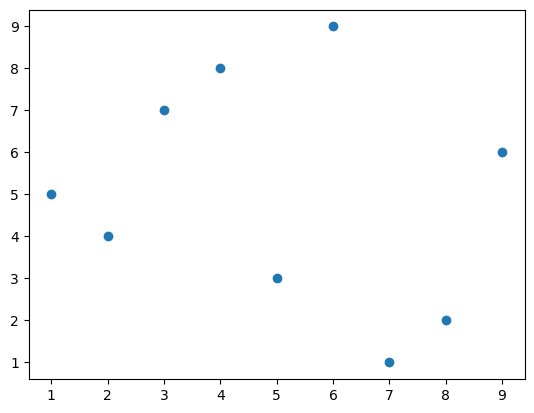

In [69]:
print(np.mean(y_pred))
print(np.std(y_pred))
print(np.mean(y_test))
print(np.std(y_test))

pred_ranks = rankdata(y_pred)
test_ranks = rankdata(y_test)

plt.scatter(test_ranks, pred_ranks)
rank_correlation = scipy.stats.spearmanr(pred_ranks, test_ranks)
print(rank_correlation)

PearsonRResult(statistic=-0.020418103376515343, pvalue=0.9584190295582661)


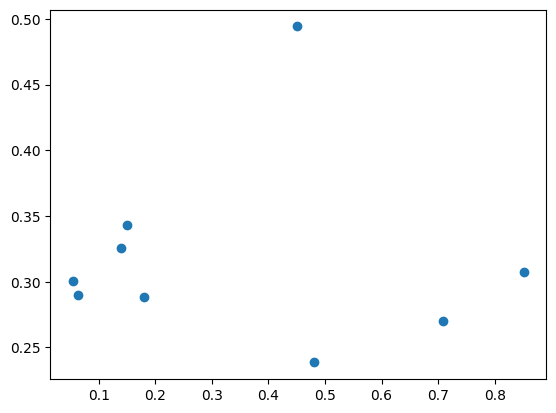

In [67]:
plt.scatter(y_test, y_pred)
correlation = scipy.stats.pearsonr(y_pred.flatten(), y_test.flatten())
print(correlation)

In [22]:
print(y_pred)
print(y_test)
print(pred_ranks)
print(test_ranks)

[[0.34366807]
 [0.32654098]
 [0.3395163 ]
 [0.4209039 ]
 [0.1314999 ]
 [0.31964806]
 [0.31017557]
 [0.44368118]
 [0.34584698]]
[[0.7086003 ]
 [0.05450395]
 [0.8513078 ]
 [0.15031968]
 [0.48065764]
 [0.18009357]
 [0.0627396 ]
 [0.45083928]
 [0.13895893]]
[6. 4. 5. 8. 1. 3. 2. 9. 7.]
[8. 1. 9. 4. 7. 5. 2. 6. 3.]


Change the depth of the neural network:

In [43]:
# Define the model
class WiderNet(nn.Module):
  def __init__(self, in_features):
    super().__init__()

    layer1_size = in_features
    layer2_size = in_features
    ##feedfoward layers:
    self.ff1 = nn.Linear(in_features, layer1_size) # input dimension is 2, first hidden layer is 10
    self.ff2 = nn.Linear(layer1_size, layer2_size) # second hidden layer is 2
    self.ff_out = nn.Linear(layer2_size, 1)  # output layer is 1

    ##activation:
    # self.act = nn.Sigmoid()
    self.act = nn.ReLU()

    if torch.cuda.is_available():
      self.cuda()


  def forward(self, input_data):
    input_data = torch.as_tensor(input_data, dtype=torch.float)
    out = self.act(self.ff1(input_data))
    out = self.act(self.ff2(out))
    out = self.ff_out(out)
    return out #returns classification for each image


  def xavier_weights(self):
    nn.init.xavier_uniform_(self.ff1.weight)
    nn.init.xavier_uniform_(self.ff2.weight)
    nn.init.xavier_uniform_(self.ff_out.weight)

0
Epoch 000: | Loss: 0.44052 | TrainErr: 0.441 | TestErr: 0.436
1
Epoch 001: | Loss: 0.42274 | TrainErr: 0.423 | TestErr: 0.421
2
Epoch 002: | Loss: 0.40583 | TrainErr: 0.406 | TestErr: 0.405
3
Epoch 003: | Loss: 0.38968 | TrainErr: 0.390 | TestErr: 0.391
4
Epoch 004: | Loss: 0.37436 | TrainErr: 0.374 | TestErr: 0.377
5
Epoch 005: | Loss: 0.35983 | TrainErr: 0.360 | TestErr: 0.364
6
Epoch 006: | Loss: 0.34605 | TrainErr: 0.346 | TestErr: 0.352
7
Epoch 007: | Loss: 0.33297 | TrainErr: 0.333 | TestErr: 0.340
8
Epoch 008: | Loss: 0.32052 | TrainErr: 0.321 | TestErr: 0.329
9
Epoch 009: | Loss: 0.30868 | TrainErr: 0.309 | TestErr: 0.319
10
Epoch 010: | Loss: 0.29743 | TrainErr: 0.297 | TestErr: 0.309
11
Epoch 011: | Loss: 0.28674 | TrainErr: 0.287 | TestErr: 0.299
12
Epoch 012: | Loss: 0.27656 | TrainErr: 0.277 | TestErr: 0.290
13
Epoch 013: | Loss: 0.26687 | TrainErr: 0.267 | TestErr: 0.282
14
Epoch 014: | Loss: 0.25767 | TrainErr: 0.258 | TestErr: 0.274
15
Epoch 015: | Loss: 0.24891 | Tra

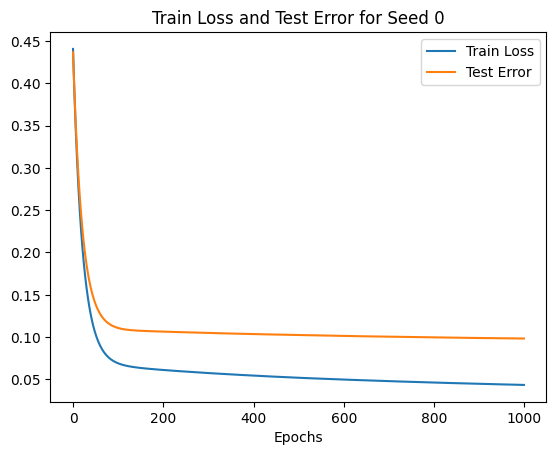

In [53]:
# Define your dataloaders
tensor_X_train = torch.Tensor(x_train_norm)
tensor_Y_train = torch.Tensor(y_train_norm)
tensor_X_test = torch.Tensor(x_test_norm)
tensor_Y_test = torch.Tensor(y_test_norm)

train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size = 10, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = 100, shuffle=False)

# instantiate model
abtiters_imputed_net = WiderNet(77)
abtiters_imputed_net.to(device)

# define optimizer and loss
# TODO: consider using adam optimizer
optimizer = torch.optim.SGD(abtiters_imputed_net.parameters(), lr = 1e-4, weight_decay=0.0)
loss_metric = nn.MSELoss()

# train model using 5 random seeds
train_accuracies = []
test_accuracies = []
epochs = 1000
for i in range(1):
  plot_data, y_pred, y_test = train_model(abtiters_imputed_net, train_loader, test_loader, epochs, i)

  train_accuracies.append(np.array(plot_data)[(epochs - 1),2])
  test_accuracies.append(np.array(plot_data)[(epochs - 1),3])

  plot_loss_acc(plot_data, i)

y_test = y_test.numpy()
y_pred = y_pred.numpy()

0.07667977
0.27682388
SignificanceResult(statistic=-0.21666666666666667, pvalue=0.5755148957119259)


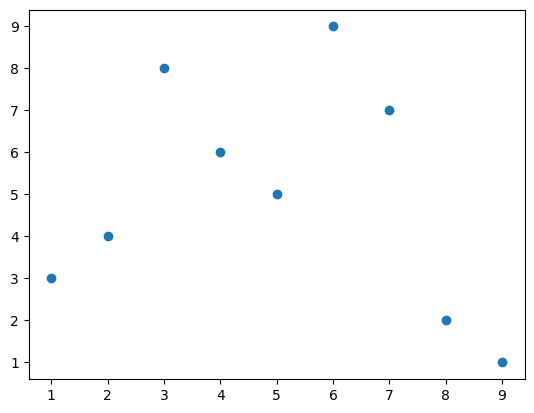

In [54]:
print(np.std(y_pred))
print(np.std(y_test))

pred_ranks = rankdata(y_pred)
test_ranks = rankdata(y_test)

plt.scatter(test_ranks, pred_ranks)
rank_correlation = scipy.stats.spearmanr(pred_ranks, test_ranks)
print(rank_correlation)

PearsonRResult(statistic=-0.3666884466308249, pvalue=0.33170887608362576)


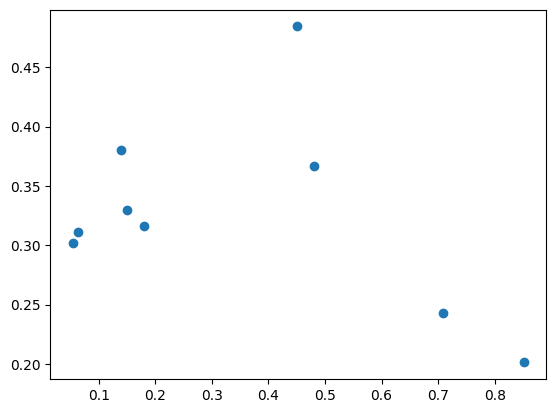

In [55]:
plt.scatter(y_test, y_pred)
correlation = scipy.stats.pearsonr(y_pred.flatten(), y_test.flatten())
print(correlation)

In [56]:
# Define the model
class DeeperNet(nn.Module):
  def __init__(self, in_features):
    super().__init__()

    layer1_size = in_features
    layer2_size = in_features
    layer3_size = in_features - round(in_features/3)
    layer4_size = in_features - round(in_features/3)
    ##feedfoward layers:
    self.ff1 = nn.Linear(in_features, layer1_size) # first hidden layer
    self.ff2 = nn.Linear(layer1_size, layer2_size) # second hidden layer
    self.ff3 = nn.Linear(layer2_size, layer3_size) # third hidden layer
    self.ff4 = nn.Linear(layer3_size, layer4_size) # fourth hidden layer
    self.ff_out = nn.Linear(layer4_size, 1)  # output layer

    ##activation:
    # self.act = nn.Sigmoid()
    self.act = nn.ReLU()

    if torch.cuda.is_available():
      self.cuda()


  def forward(self, input_data):
    input_data = torch.as_tensor(input_data, dtype=torch.float)
    out = self.act(self.ff1(input_data))
    out = self.act(self.ff2(out))
    out = self.act(self.ff3(out))
    out = self.act(self.ff4(out))
    out = self.ff_out(out)
    return out #returns classification for each image


  def xavier_weights(self):
    nn.init.xavier_uniform_(self.ff1.weight)
    nn.init.xavier_uniform_(self.ff2.weight)
    nn.init.xavier_uniform_(self.ff3.weight)
    nn.init.xavier_uniform_(self.ff4.weight)
    nn.init.xavier_uniform_(self.ff_out.weight)

0
Epoch 000: | Loss: 0.39207 | TrainErr: 0.392 | TestErr: 0.433
1
Epoch 001: | Loss: 0.38247 | TrainErr: 0.382 | TestErr: 0.424
2
Epoch 002: | Loss: 0.37320 | TrainErr: 0.373 | TestErr: 0.415
3
Epoch 003: | Loss: 0.36423 | TrainErr: 0.364 | TestErr: 0.406
4
Epoch 004: | Loss: 0.35557 | TrainErr: 0.356 | TestErr: 0.397
5
Epoch 005: | Loss: 0.34720 | TrainErr: 0.347 | TestErr: 0.389
6
Epoch 006: | Loss: 0.33910 | TrainErr: 0.339 | TestErr: 0.381
7
Epoch 007: | Loss: 0.33126 | TrainErr: 0.331 | TestErr: 0.374
8
Epoch 008: | Loss: 0.32367 | TrainErr: 0.324 | TestErr: 0.366
9
Epoch 009: | Loss: 0.31632 | TrainErr: 0.316 | TestErr: 0.359
10
Epoch 010: | Loss: 0.30919 | TrainErr: 0.309 | TestErr: 0.352
11
Epoch 011: | Loss: 0.30230 | TrainErr: 0.302 | TestErr: 0.345
12
Epoch 012: | Loss: 0.29576 | TrainErr: 0.296 | TestErr: 0.339
13
Epoch 013: | Loss: 0.28945 | TrainErr: 0.289 | TestErr: 0.333
14
Epoch 014: | Loss: 0.28334 | TrainErr: 0.283 | TestErr: 0.326
15
Epoch 015: | Loss: 0.27741 | Tra

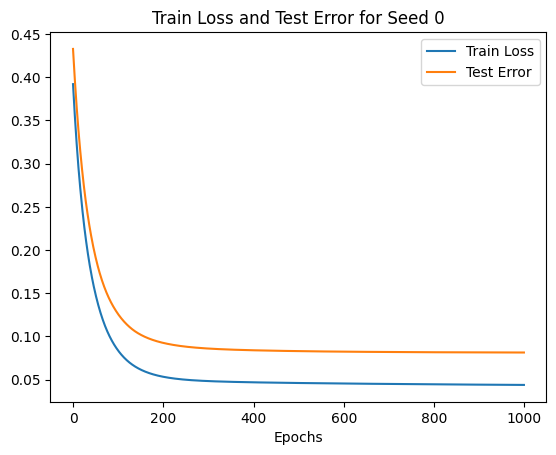

In [59]:
# Define your dataloaders
tensor_X_train = torch.Tensor(x_train_norm)
tensor_Y_train = torch.Tensor(y_train_norm)
tensor_X_test = torch.Tensor(x_test_norm)
tensor_Y_test = torch.Tensor(y_test_norm)

train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size = 10, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = 100, shuffle=False)

# instantiate model
abtiters_imputed_net = DeeperNet(77)
abtiters_imputed_net.to(device)

# define optimizer and loss
# TODO: consider using adam optimizer
optimizer = torch.optim.SGD(abtiters_imputed_net.parameters(), lr = 1e-4, weight_decay=0.1)
loss_metric = nn.MSELoss()

# train model using 5 random seeds
train_accuracies = []
test_accuracies = []
epochs = 1000
for i in range(1):
  plot_data, y_pred, y_test = train_model(abtiters_imputed_net, train_loader, test_loader, epochs, i)

  train_accuracies.append(np.array(plot_data)[(epochs - 1),2])
  test_accuracies.append(np.array(plot_data)[(epochs - 1),3])

  plot_loss_acc(plot_data, i)

y_test = y_test.numpy()
y_pred = y_pred.numpy()

0.011923573
0.27682388
SignificanceResult(statistic=-0.4666666666666666, pvalue=0.20538635110581185)


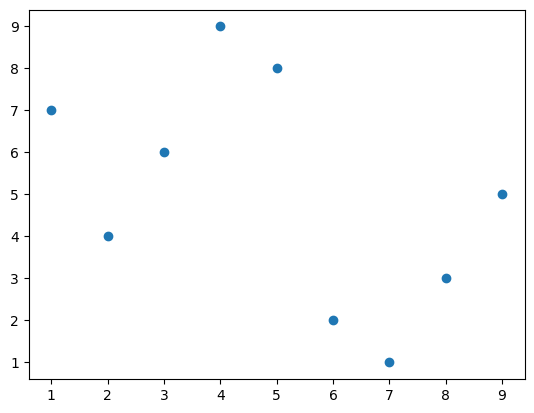

In [60]:
print(np.std(y_pred))
print(np.std(y_test))

pred_ranks = rankdata(y_pred)
test_ranks = rankdata(y_test)

plt.scatter(test_ranks, pred_ranks)
rank_correlation = scipy.stats.spearmanr(pred_ranks, test_ranks)
print(rank_correlation)